In [2]:
# nalozimo potrebne knjiznice
from sage.all import *
import random
import math
from sage.graphs.graph_generators import graphs
from sage.graphs.graph import Graph
from sage.numerical.mip import MixedIntegerLinearProgram
from sage.numerical.mip import MIPSolverException

In [3]:
def razdalja(moznost, vozlisce, G):
    c, a = moznost
    if c == 'e':
        U, V = a
        return min(G.distance(U, vozlisce), G.distance(V, vozlisce))
    else:
        return G.distance(a, vozlisce)

In [4]:
def CLP_weak_mixed_k_dim(G, k):
    p = MixedIntegerLinearProgram(maximization=False)
    x = p.new_variable(binary=True)

    V = G.vertices()
    E = G.edges(labels=False)

    moznosti = [('v', v) for v in V] + [('e', e) for e in E]

    p.set_objective(sum(x[v] for v in V))
    
    for a, b in Combinations(moznosti, 2):
        p.add_constraint(
            sum(abs(razdalja(a, v, G) - razdalja(b, v, G)) * x[v] for v in V) >= k
            )

    wmdim_k = p.solve()
    mnozica_S = [v for v in V if p.get_values(x[v]) > 0.5]

    return (wmdim_k, mnozica_S)

In [5]:
def kappa_2_crti(G):
    k = 1
    while True:
        try:
            CLP_weak_mixed_k_dim(G, k)
            k += 1
        except:
            return k - 1

In [6]:
def generate_random_connected_graph(n, p):
    
    while True:
        G = graphs.RandomGNP(n, p)
        if G.is_connected():
            return G


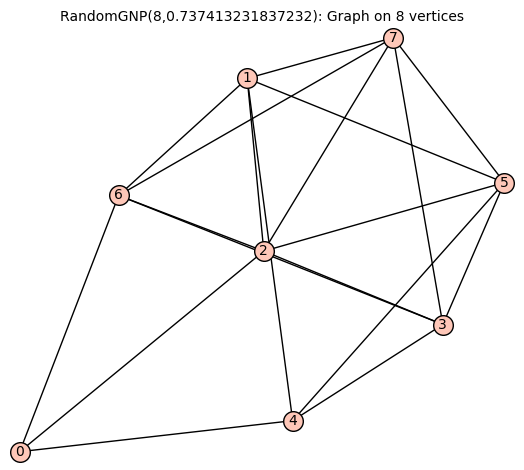

In [30]:
generate_random_connected_graph(8, random.uniform(0.2, 0.8))

In [10]:
def simulated_annealing(n, k, target_wmdim, max_iterations=1000, initial_temp=10, cooling_rate=0.95):
    
    def generate_new_graph():
        return generate_random_connected_graph(n, random.uniform(0.2, 0.8))

    current_graph = generate_new_graph()
    current_temp = initial_temp

    def objective(graph):
        try:
            wmdim_k, _ = CLP_weak_mixed_k_dim(graph, k)
            return abs(wmdim_k - target_wmdim), wmdim_k
        except (ValueError, MIPSolverException):
            return float('inf'), None

    current_cost, current_wmdim = objective(current_graph)
    best_graph = current_graph
    best_cost = current_cost
    best_wmdim = current_wmdim

    none_count = 0 

    for iteration in range(max_iterations):
        if none_count >= 20:  
            print("Regenerating graph due to 20 consecutive None values for current_wmdim.")
            current_graph = generate_new_graph()
            current_cost, current_wmdim = objective(current_graph)
            none_count = 0  

        new_graph = current_graph.copy()
        if random.random() < 0.5:
            u, v = random.sample(range(n), 2)
            if not new_graph.has_edge(u, v):
                new_graph.add_edge(u, v)
        else:
            if new_graph.size() > n - 1:
                u, v = random.choice(new_graph.edges(labels=False))
                new_graph.delete_edge(u, v)
        
        if not new_graph.is_connected():
            continue

        new_cost, new_wmdim = objective(new_graph)

        if new_wmdim is None:
            none_count += 1  
        else:
            none_count = 0  

        if new_cost < current_cost or random.random() < math.exp((current_cost - new_cost) / current_temp):
            current_graph = new_graph
            current_cost = new_cost
            current_wmdim = new_wmdim
            if current_cost < best_cost:
                best_graph = current_graph
                best_cost = current_cost
                best_wmdim = current_wmdim

        current_temp *= cooling_rate
        print(f"Iteration {iteration + 1}: Current wmdim_k = {current_wmdim}, Best wmdim_k = {best_wmdim}")

        if best_cost == 0:
            break

    return best_graph, best_wmdim


Iteration 1: Current wmdim_k = 17.0, Best wmdim_k = 17.0
Iteration 2: Current wmdim_k = 16.0, Best wmdim_k = 16.0
Iteration 3: Current wmdim_k = 16.0, Best wmdim_k = 16.0
Iteration 4: Current wmdim_k = 16.0, Best wmdim_k = 16.0
Iteration 5: Current wmdim_k = 16.0, Best wmdim_k = 16.0
Iteration 6: Current wmdim_k = 16.0, Best wmdim_k = 16.0
Iteration 7: Current wmdim_k = 16.0, Best wmdim_k = 16.0
Iteration 8: Current wmdim_k = 16.0, Best wmdim_k = 16.0
Iteration 9: Current wmdim_k = 16.0, Best wmdim_k = 16.0
Iteration 10: Current wmdim_k = 16.0, Best wmdim_k = 16.0
Iteration 11: Current wmdim_k = 16.0, Best wmdim_k = 16.0
Iteration 12: Current wmdim_k = 16.0, Best wmdim_k = 16.0
Iteration 13: Current wmdim_k = 16.0, Best wmdim_k = 16.0
Iteration 14: Current wmdim_k = 16.0, Best wmdim_k = 16.0
Iteration 15: Current wmdim_k = 16.0, Best wmdim_k = 16.0
Iteration 16: Current wmdim_k = 16.0, Best wmdim_k = 16.0
Iteration 17: Current wmdim_k = 16.0, Best wmdim_k = 16.0
Iteration 18: Current w

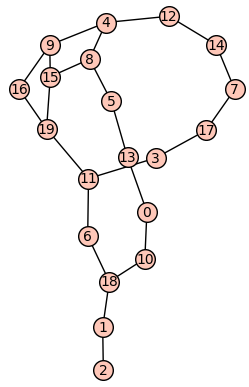

In [9]:
n = 20
k = 1
target_wmdim = 3
max_iterations = 5000
initial_temp = 10
cooling_rate = 0.95

best_graph, best_wmdim = simulated_annealing(n, k, target_wmdim, max_iterations, initial_temp, cooling_rate)

print("\nBest Graph Found:")
print(f"wmdim_k = {best_wmdim}")
print("Adjacency Matrix:")
print(best_graph.adjacency_matrix())
best_graph.show()

Iteration 1: Current wmdim_k = 10.0, Best wmdim_k = 10.0
Iteration 2: Current wmdim_k = 10.0, Best wmdim_k = 10.0
Iteration 3: Current wmdim_k = 9.0, Best wmdim_k = 10.0
Iteration 4: Current wmdim_k = 9.0, Best wmdim_k = 10.0
Iteration 5: Current wmdim_k = 9.0, Best wmdim_k = 10.0
Iteration 6: Current wmdim_k = 9.0, Best wmdim_k = 10.0
Iteration 7: Current wmdim_k = 10.0, Best wmdim_k = 10.0
Iteration 8: Current wmdim_k = 10.0, Best wmdim_k = 10.0
Iteration 9: Current wmdim_k = 10.0, Best wmdim_k = 10.0
Iteration 10: Current wmdim_k = 10.0, Best wmdim_k = 10.0
Iteration 11: Current wmdim_k = 10.0, Best wmdim_k = 10.0
Iteration 12: Current wmdim_k = 10.0, Best wmdim_k = 10.0
Iteration 13: Current wmdim_k = 10.0, Best wmdim_k = 10.0
Iteration 14: Current wmdim_k = 10.0, Best wmdim_k = 10.0
Iteration 15: Current wmdim_k = 10.0, Best wmdim_k = 10.0
Iteration 16: Current wmdim_k = 10.0, Best wmdim_k = 10.0
Iteration 17: Current wmdim_k = 10.0, Best wmdim_k = 10.0
Iteration 18: Current wmdim

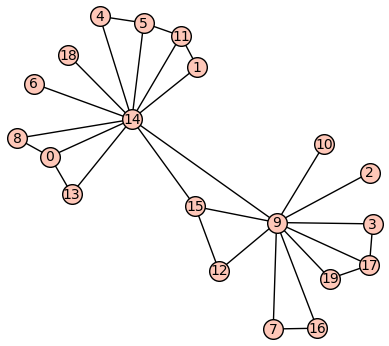

In [18]:
n = 20
k = 1
target_wmdim = n-2
max_iterations = 2000
initial_temp = 10
cooling_rate = 0.95

best_graph, best_wmdim = simulated_annealing(n, k, target_wmdim, max_iterations, initial_temp, cooling_rate)

print("\nBest Graph Found:")
print(f"wmdim_k = {best_wmdim}")
print("Adjacency Matrix:")
print(best_graph.adjacency_matrix())
best_graph.show()

Iteration 1: Current wmdim_k = 17.0, Best wmdim_k = 17.0
Iteration 2: Current wmdim_k = 17.0, Best wmdim_k = 17.0
Iteration 3: Current wmdim_k = 17.0, Best wmdim_k = 17.0
Iteration 4: Current wmdim_k = 17.0, Best wmdim_k = 17.0
Iteration 5: Current wmdim_k = 17.0, Best wmdim_k = 17.0
Iteration 6: Current wmdim_k = 16.0, Best wmdim_k = 17.0
Iteration 7: Current wmdim_k = 16.0, Best wmdim_k = 17.0
Iteration 8: Current wmdim_k = 16.0, Best wmdim_k = 17.0
Iteration 9: Current wmdim_k = 16.0, Best wmdim_k = 17.0
Iteration 10: Current wmdim_k = 16.0, Best wmdim_k = 17.0
Iteration 11: Current wmdim_k = 16.0, Best wmdim_k = 17.0
Iteration 12: Current wmdim_k = 16.0, Best wmdim_k = 17.0
Iteration 13: Current wmdim_k = 16.0, Best wmdim_k = 17.0
Iteration 14: Current wmdim_k = 15.0, Best wmdim_k = 17.0
Iteration 15: Current wmdim_k = 15.0, Best wmdim_k = 17.0
Iteration 16: Current wmdim_k = 15.0, Best wmdim_k = 17.0
Iteration 17: Current wmdim_k = 15.0, Best wmdim_k = 17.0
Iteration 18: Current w

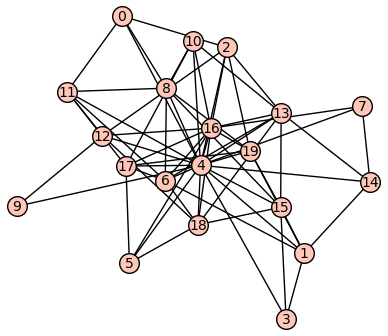

In [19]:
n = 20
k = 1
target_wmdim = n-1
max_iterations = 2000
initial_temp = 10
cooling_rate = 0.95

best_graph, best_wmdim = simulated_annealing(n, k, target_wmdim, max_iterations, initial_temp, cooling_rate)

print("\nBest Graph Found:")
print(f"wmdim_k = {best_wmdim}")
print("Adjacency Matrix:")
print(best_graph.adjacency_matrix())
best_graph.show()

Iteration 1: Current wmdim_k = 10.0, Best wmdim_k = 10.0
Iteration 2: Current wmdim_k = 10.0, Best wmdim_k = 10.0
Iteration 3: Current wmdim_k = 10.0, Best wmdim_k = 10.0
Iteration 4: Current wmdim_k = 10.0, Best wmdim_k = 10.0
Iteration 5: Current wmdim_k = 10.0, Best wmdim_k = 10.0
Iteration 6: Current wmdim_k = 10.0, Best wmdim_k = 10.0
Iteration 7: Current wmdim_k = 10.0, Best wmdim_k = 10.0
Iteration 8: Current wmdim_k = 10.0, Best wmdim_k = 10.0
Iteration 9: Current wmdim_k = 10.0, Best wmdim_k = 10.0
Iteration 10: Current wmdim_k = 10.0, Best wmdim_k = 10.0
Iteration 11: Current wmdim_k = 10.0, Best wmdim_k = 10.0
Iteration 12: Current wmdim_k = 10.0, Best wmdim_k = 10.0
Iteration 13: Current wmdim_k = 10.0, Best wmdim_k = 10.0
Iteration 14: Current wmdim_k = 10.0, Best wmdim_k = 10.0
Iteration 15: Current wmdim_k = 10.0, Best wmdim_k = 10.0
Iteration 16: Current wmdim_k = 10.0, Best wmdim_k = 10.0
Iteration 17: Current wmdim_k = 10.0, Best wmdim_k = 10.0
Iteration 18: Current w

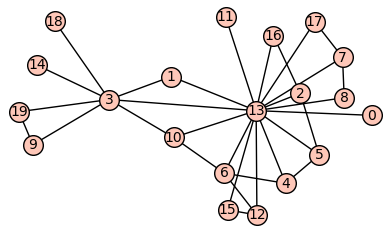

In [20]:
n = 20
k = 1
target_wmdim = n
max_iterations = 2000
initial_temp = 10
cooling_rate = 0.95

best_graph, best_wmdim = simulated_annealing(n, k, target_wmdim, max_iterations, initial_temp, cooling_rate)

print("\nBest Graph Found:")
print(f"wmdim_k = {best_wmdim}")
print("Adjacency Matrix:")
print(best_graph.adjacency_matrix())
best_graph.show()

Iteration 1: Current wmdim_k = 19.0, Best wmdim_k = 19.0
Iteration 2: Current wmdim_k = 20.0, Best wmdim_k = 19.0
Iteration 3: Current wmdim_k = 20.0, Best wmdim_k = 19.0
Iteration 4: Current wmdim_k = 20.0, Best wmdim_k = 19.0
Iteration 5: Current wmdim_k = 18.0, Best wmdim_k = 18.0
Iteration 6: Current wmdim_k = 18.0, Best wmdim_k = 18.0
Iteration 7: Current wmdim_k = 18.0, Best wmdim_k = 18.0
Iteration 8: Current wmdim_k = 18.0, Best wmdim_k = 18.0
Iteration 9: Current wmdim_k = 18.0, Best wmdim_k = 18.0
Iteration 10: Current wmdim_k = 18.0, Best wmdim_k = 18.0
Iteration 11: Current wmdim_k = 18.0, Best wmdim_k = 18.0
Iteration 12: Current wmdim_k = 18.0, Best wmdim_k = 18.0
Iteration 13: Current wmdim_k = 18.0, Best wmdim_k = 18.0
Iteration 14: Current wmdim_k = 18.0, Best wmdim_k = 18.0
Iteration 15: Current wmdim_k = 18.0, Best wmdim_k = 18.0
Iteration 16: Current wmdim_k = 18.0, Best wmdim_k = 18.0
Iteration 17: Current wmdim_k = 18.0, Best wmdim_k = 18.0
Iteration 18: Current w

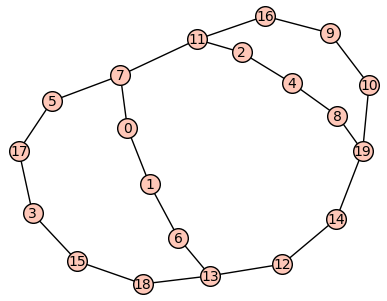

In [15]:
n = 20
k = 2
target_wmdim = 3
max_iterations = 5000
initial_temp = 10
cooling_rate = 0.97

best_graph, best_wmdim = simulated_annealing(n, k, target_wmdim, max_iterations, initial_temp, cooling_rate)

print("\nBest Graph Found:")
print(f"wmdim_k = {best_wmdim}")
print("Adjacency Matrix:")
print(best_graph.adjacency_matrix())
best_graph.show()

Iteration 1: Current wmdim_k = 14.0, Best wmdim_k = 14.0
Iteration 2: Current wmdim_k = 14.0, Best wmdim_k = 14.0
Iteration 3: Current wmdim_k = 14.0, Best wmdim_k = 14.0
Iteration 4: Current wmdim_k = 14.0, Best wmdim_k = 14.0
Iteration 5: Current wmdim_k = 14.0, Best wmdim_k = 14.0
Iteration 6: Current wmdim_k = 14.0, Best wmdim_k = 14.0
Iteration 7: Current wmdim_k = 14.0, Best wmdim_k = 14.0
Iteration 8: Current wmdim_k = 14.0, Best wmdim_k = 14.0
Iteration 9: Current wmdim_k = 13.0, Best wmdim_k = 14.0
Iteration 10: Current wmdim_k = 14.0, Best wmdim_k = 14.0
Iteration 11: Current wmdim_k = 14.0, Best wmdim_k = 14.0
Iteration 12: Current wmdim_k = 14.0, Best wmdim_k = 14.0
Iteration 13: Current wmdim_k = 14.0, Best wmdim_k = 14.0
Iteration 14: Current wmdim_k = 15.0, Best wmdim_k = 15.0
Iteration 15: Current wmdim_k = 15.0, Best wmdim_k = 15.0
Iteration 16: Current wmdim_k = 14.0, Best wmdim_k = 15.0
Iteration 17: Current wmdim_k = 14.0, Best wmdim_k = 15.0
Iteration 18: Current w

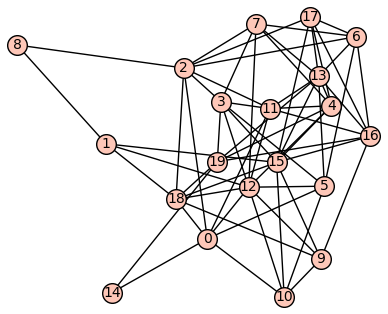

In [10]:
n = 20
k = 2
target_wmdim = n-2
max_iterations = 500
initial_temp = 10
cooling_rate = 0.95

best_graph, best_wmdim = simulated_annealing(n, k, target_wmdim, max_iterations, initial_temp, cooling_rate)

print("\nBest Graph Found:")
print(f"wmdim_k = {best_wmdim}")
print("Adjacency Matrix:")
print(best_graph.adjacency_matrix())
best_graph.show()

Iteration 1: Current wmdim_k = 17.0, Best wmdim_k = 17.0
Iteration 2: Current wmdim_k = 18.0, Best wmdim_k = 18.0
Iteration 3: Current wmdim_k = 17.0, Best wmdim_k = 18.0
Iteration 4: Current wmdim_k = 17.0, Best wmdim_k = 18.0
Iteration 5: Current wmdim_k = 17.0, Best wmdim_k = 18.0
Iteration 6: Current wmdim_k = 17.0, Best wmdim_k = 18.0
Iteration 7: Current wmdim_k = 17.0, Best wmdim_k = 18.0
Iteration 8: Current wmdim_k = 17.0, Best wmdim_k = 18.0
Iteration 9: Current wmdim_k = 17.0, Best wmdim_k = 18.0
Iteration 10: Current wmdim_k = 17.0, Best wmdim_k = 18.0
Iteration 11: Current wmdim_k = 18.0, Best wmdim_k = 18.0
Iteration 12: Current wmdim_k = 18.0, Best wmdim_k = 18.0
Iteration 13: Current wmdim_k = 18.0, Best wmdim_k = 18.0
Iteration 14: Current wmdim_k = 18.0, Best wmdim_k = 18.0
Iteration 15: Current wmdim_k = 18.0, Best wmdim_k = 18.0
Iteration 16: Current wmdim_k = 18.0, Best wmdim_k = 18.0
Iteration 17: Current wmdim_k = 18.0, Best wmdim_k = 18.0
Iteration 18: Current w

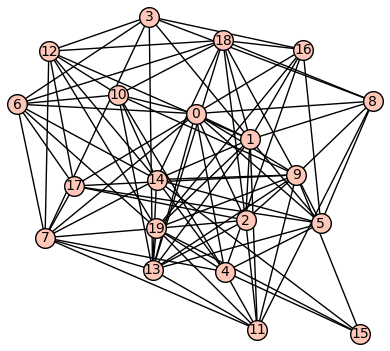

In [9]:
n = 20
k = 2
target_wmdim = n-1
max_iterations = 500
initial_temp = 10
cooling_rate = 0.95

best_graph, best_wmdim = simulated_annealing(n, k, target_wmdim, max_iterations, initial_temp, cooling_rate)

print("\nBest Graph Found:")
print(f"wmdim_k = {best_wmdim}")
print("Adjacency Matrix:")
print(best_graph.adjacency_matrix())
best_graph.show()

Iteration 1: Current wmdim_k = 18.0, Best wmdim_k = 19.0
Iteration 2: Current wmdim_k = 18.0, Best wmdim_k = 19.0
Iteration 3: Current wmdim_k = 18.0, Best wmdim_k = 19.0
Iteration 4: Current wmdim_k = 18.0, Best wmdim_k = 19.0
Iteration 5: Current wmdim_k = 18.0, Best wmdim_k = 19.0
Iteration 6: Current wmdim_k = 18.0, Best wmdim_k = 19.0
Iteration 7: Current wmdim_k = 18.0, Best wmdim_k = 19.0
Iteration 8: Current wmdim_k = 18.0, Best wmdim_k = 19.0
Iteration 9: Current wmdim_k = 18.0, Best wmdim_k = 19.0
Iteration 10: Current wmdim_k = 18.0, Best wmdim_k = 19.0
Iteration 11: Current wmdim_k = 18.0, Best wmdim_k = 19.0
Iteration 12: Current wmdim_k = 18.0, Best wmdim_k = 19.0
Iteration 13: Current wmdim_k = 18.0, Best wmdim_k = 19.0
Iteration 14: Current wmdim_k = 18.0, Best wmdim_k = 19.0
Iteration 15: Current wmdim_k = 18.0, Best wmdim_k = 19.0
Iteration 16: Current wmdim_k = 18.0, Best wmdim_k = 19.0
Iteration 17: Current wmdim_k = 20.0, Best wmdim_k = 20.0

Best Graph Found:
wmdi

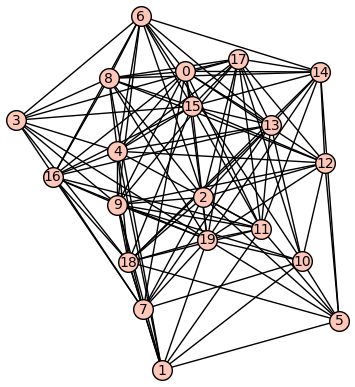

In [8]:
n = 20
k = 2
target_wmdim = n
max_iterations = 500
initial_temp = 10
cooling_rate = 0.95

best_graph, best_wmdim = simulated_annealing(n, k, target_wmdim, max_iterations, initial_temp, cooling_rate)

print("\nBest Graph Found:")
print(f"wmdim_k = {best_wmdim}")
print("Adjacency Matrix:")
print(best_graph.adjacency_matrix())
best_graph.show()

Iteration 1: Current wmdim_k = None, Best wmdim_k = None
Iteration 2: Current wmdim_k = None, Best wmdim_k = None
Iteration 3: Current wmdim_k = None, Best wmdim_k = None
Iteration 4: Current wmdim_k = None, Best wmdim_k = None
Iteration 5: Current wmdim_k = None, Best wmdim_k = None
Iteration 6: Current wmdim_k = None, Best wmdim_k = None
Iteration 7: Current wmdim_k = None, Best wmdim_k = None
Iteration 8: Current wmdim_k = None, Best wmdim_k = None
Iteration 9: Current wmdim_k = None, Best wmdim_k = None
Iteration 10: Current wmdim_k = None, Best wmdim_k = None
Iteration 11: Current wmdim_k = None, Best wmdim_k = None
Iteration 12: Current wmdim_k = None, Best wmdim_k = None
Iteration 13: Current wmdim_k = None, Best wmdim_k = None
Iteration 14: Current wmdim_k = None, Best wmdim_k = None
Iteration 15: Current wmdim_k = None, Best wmdim_k = None
Iteration 16: Current wmdim_k = None, Best wmdim_k = None
Iteration 17: Current wmdim_k = None, Best wmdim_k = None
Iteration 18: Current w

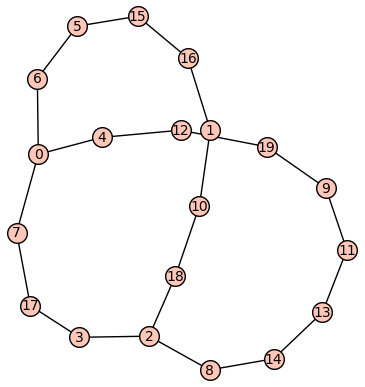

In [11]:
n = 20
k = 3
target_wmdim = 3
max_iterations = 5000
initial_temp = 10
cooling_rate = 0.95

best_graph, best_wmdim = simulated_annealing(n, k, target_wmdim, max_iterations, initial_temp, cooling_rate)

print("\nBest Graph Found:")
print(f"wmdim_k = {best_wmdim}")
print("Adjacency Matrix:")
print(best_graph.adjacency_matrix())
best_graph.show()

Iteration 1: Current wmdim_k = None, Best wmdim_k = None
Iteration 2: Current wmdim_k = None, Best wmdim_k = None
Iteration 3: Current wmdim_k = None, Best wmdim_k = None
Iteration 4: Current wmdim_k = None, Best wmdim_k = None
Iteration 5: Current wmdim_k = None, Best wmdim_k = None
Iteration 6: Current wmdim_k = None, Best wmdim_k = None
Iteration 7: Current wmdim_k = None, Best wmdim_k = None
Iteration 8: Current wmdim_k = None, Best wmdim_k = None
Iteration 9: Current wmdim_k = None, Best wmdim_k = None
Iteration 10: Current wmdim_k = None, Best wmdim_k = None
Iteration 11: Current wmdim_k = None, Best wmdim_k = None
Iteration 12: Current wmdim_k = None, Best wmdim_k = None
Iteration 13: Current wmdim_k = None, Best wmdim_k = None
Iteration 14: Current wmdim_k = None, Best wmdim_k = None
Iteration 15: Current wmdim_k = None, Best wmdim_k = None
Iteration 16: Current wmdim_k = None, Best wmdim_k = None
Iteration 17: Current wmdim_k = None, Best wmdim_k = None
Iteration 18: Current w

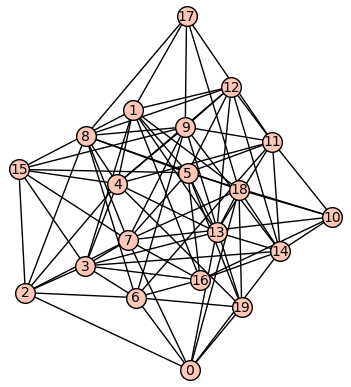

In [12]:
n = 20
k = 3
target_wmdim = n-2
max_iterations = 5000
initial_temp = 10
cooling_rate = 0.95

best_graph, best_wmdim = simulated_annealing(n, k, target_wmdim, max_iterations, initial_temp, cooling_rate)

print("\nBest Graph Found:")
print(f"wmdim_k = {best_wmdim}")
print("Adjacency Matrix:")
print(best_graph.adjacency_matrix())
best_graph.show()

Iteration 1: Current wmdim_k = None, Best wmdim_k = None
Iteration 2: Current wmdim_k = None, Best wmdim_k = None
Iteration 3: Current wmdim_k = None, Best wmdim_k = None
Iteration 4: Current wmdim_k = None, Best wmdim_k = None
Iteration 5: Current wmdim_k = None, Best wmdim_k = None
Iteration 6: Current wmdim_k = None, Best wmdim_k = None
Iteration 7: Current wmdim_k = None, Best wmdim_k = None
Iteration 8: Current wmdim_k = None, Best wmdim_k = None
Iteration 9: Current wmdim_k = None, Best wmdim_k = None
Iteration 10: Current wmdim_k = None, Best wmdim_k = None
Iteration 11: Current wmdim_k = None, Best wmdim_k = None
Iteration 12: Current wmdim_k = None, Best wmdim_k = None
Iteration 13: Current wmdim_k = None, Best wmdim_k = None
Iteration 14: Current wmdim_k = None, Best wmdim_k = None
Iteration 15: Current wmdim_k = None, Best wmdim_k = None
Iteration 16: Current wmdim_k = None, Best wmdim_k = None
Iteration 17: Current wmdim_k = None, Best wmdim_k = None
Iteration 18: Current w

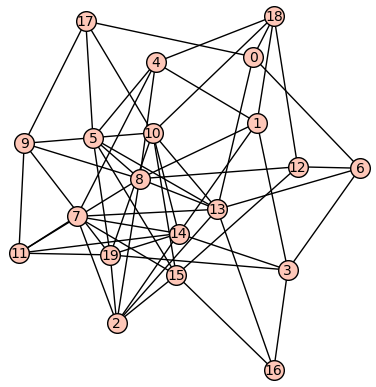

In [13]:
n = 20
k = 3
target_wmdim = n-1
max_iterations = 5000
initial_temp = 10
cooling_rate = 0.95

best_graph, best_wmdim = simulated_annealing(n, k, target_wmdim, max_iterations, initial_temp, cooling_rate)

print("\nBest Graph Found:")
print(f"wmdim_k = {best_wmdim}")
print("Adjacency Matrix:")
print(best_graph.adjacency_matrix())
best_graph.show()

Iteration 1: Current wmdim_k = None, Best wmdim_k = None
Iteration 2: Current wmdim_k = None, Best wmdim_k = None
Iteration 3: Current wmdim_k = None, Best wmdim_k = None
Iteration 4: Current wmdim_k = None, Best wmdim_k = None
Iteration 5: Current wmdim_k = None, Best wmdim_k = None
Iteration 6: Current wmdim_k = None, Best wmdim_k = None
Iteration 7: Current wmdim_k = None, Best wmdim_k = None
Iteration 8: Current wmdim_k = None, Best wmdim_k = None
Iteration 9: Current wmdim_k = None, Best wmdim_k = None
Iteration 10: Current wmdim_k = None, Best wmdim_k = None
Iteration 11: Current wmdim_k = None, Best wmdim_k = None
Iteration 12: Current wmdim_k = None, Best wmdim_k = None
Iteration 13: Current wmdim_k = None, Best wmdim_k = None
Iteration 14: Current wmdim_k = None, Best wmdim_k = None
Iteration 15: Current wmdim_k = None, Best wmdim_k = None
Iteration 16: Current wmdim_k = None, Best wmdim_k = None
Iteration 17: Current wmdim_k = None, Best wmdim_k = None
Iteration 18: Current w

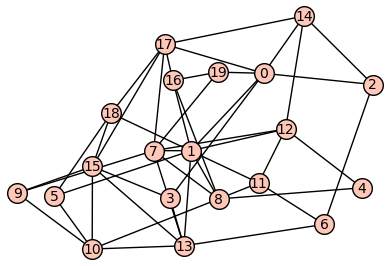

In [14]:
n = 20
k = 3
target_wmdim = n
max_iterations = 5000
initial_temp = 10
cooling_rate = 0.95

best_graph, best_wmdim = simulated_annealing(n, k, target_wmdim, max_iterations, initial_temp, cooling_rate)

print("\nBest Graph Found:")
print(f"wmdim_k = {best_wmdim}")
print("Adjacency Matrix:")
print(best_graph.adjacency_matrix())
best_graph.show()